In [1]:
import aiida

# must execute it in the first place
aiida.load_profile()

In [2]:
from aiida.orm import Code
from aiida.orm import Str, Int, Dict, List
from aiida.engine import calcfunction, WorkChain, ToContext, append_
from aiida.plugins import DataFactory, WorkflowFactory
from itertools import cycle
import os

from aiida.engine import calcfunction, workfunction, submit, run
from aiida.orm import load_code,load_node
from tools import wait_for_node_finished

# load types
StructureData = DataFactory('structure')
FolderData = DataFactory('folder')
SinglefileData = DataFactory('singlefile')
ArrayData = DataFactory('array')
List = DataFactory('list')


In [3]:
# codeの定義を行う。
from tools.aiida_support import get_or_create_local_computer, get_or_create_code
from os.path import expanduser
import os
home = expanduser("~")
work_directory = os.path.join(home,'aiida')
computer_local = get_or_create_local_computer(work_directory, 'localhost')
code = get_or_create_code('alamode.alm_opt', 
                          computer_local, 
                          '/home/max/Documents/alamode/bin/alm')
code_alm_opt = code
code = get_or_create_code('alamode.anphon', 
                          computer_local, 
                          '/home/max/Documents/alamode/bin/anphon')
code_anphon = code
code = get_or_create_code('alamode.analyze_phonons', 
                          computer_local, 
                          '/home/max/Documents/alamode/bin/analyze_phonons')
code_analyze_phonons = code
code_alm_opt, code_anphon, code_analyze_phonons

(<Code: Remote code 'alamode.alm_opt' on localhost, pk: 59276, uuid: f978b37c-4404-4f61-ba70-2a2d6b8ad201>,
 <Code: Remote code 'alamode.anphon' on localhost, pk: 59277, uuid: dc42525d-6e01-4b6c-8568-b3fb3b14f6b2>,
 <Code: Remote code 'alamode.analyze_phonons' on localhost, pk: 59607, uuid: c586f40b-2354-4163-bf6e-69ef3062115e>)

In [4]:
import json
with open("setting.json") as f:
    _dic = json.load(f)
print(_dic)
CWD = _dic["CWD"]
_path = os.path.abspath(CWD)
os.makedirs(_path, exist_ok=True)
_path

{'CWD': 'run29'}


'/home/max/Documents/aiida-test/alamode-aiida/example/run29'

In [5]:
from os.path import expanduser
from tools import NodeBank


# 再実行時に作成したノードを用いるためにnodebankを使う。
g_force = False
nodebank = NodeBank(_path, force=g_force)

In [6]:
g_norder = nodebank.load("cubic_norder")
g_prefix = nodebank.load('cubic_prefix')
g_norder, g_prefix

(<Int: uuid: 024283bc-0bab-4a13-be6c-06e64a7c70dc (pk: 59328) value: 2>,
 <Str: uuid: c712e126-400d-4846-9bbf-772c331c7f2b (pk: 59329) value: cubic>)

In [7]:
g_cwd = nodebank.load("cubic_cwd") # 保存directory
# g_dispfile_folder = nodebank.load("cubic_dispfile_folder")
# g_displace_result = nodebank.load("cubic_displace_result")
g_superstructure = nodebank.load("superstructure") # 長周期構造

g_lammps_all_output = nodebank.load(f'{g_prefix.value}_all_dfset')
g_cwd, g_lammps_all_output

(<Str: uuid: 7311e76c-dddc-474a-88ac-81014ccec5cb (pk: 59331) value: /home/max/Documents/aiida-test/alamode-aiida/example/run29/Ga2N2_1x1x1_cubic>,
 None)

In [8]:
node = nodebank.load(f'{g_prefix.value}_extract')
g_DFSET_file = node.outputs.dfset_file
g_DFSET_file.attributes

{'filename': 'DFSET_cubic'}

# alm opt 

In [9]:
g_norder

<Int: uuid: 024283bc-0bab-4a13-be6c-06e64a7c70dc (pk: 59328) value: 2>

In [10]:
g_diag = nodebank.load("diag")
g_diag.get_array('diag')

array([1, 1, 1])

In [11]:
g_primstructure = nodebank.load("primstructure")
g_primstructure

<StructureData: uuid: f222a7ce-53e6-4d9d-b868-6b57cd8a2c92 (pk: 59111)>

In [12]:

g_almprefix = "_".join([g_primstructure.get_formula(),"x".join(map(str,g_diag.get_array("diag"))), "cubic"])
g_almprefix = Str(g_almprefix)

g_wd = nodebank.load_or_dump("cubic_almprefix",g_almprefix) # subdirectory名
g_DFSET_file, g_almprefix, g_wd

debug, node uuid: 0ee7cbfb-27b4-42a8-bd35-99c220e79d88 (unstored) value: Ga2N2_1x1x1_cubic
debug, load None
debug, force dump


(<SinglefileData: uuid: 1119c673-67b1-4133-8535-6fa3abdd70fb (pk: 59606)>,
 <Str: uuid: 0ee7cbfb-27b4-42a8-bd35-99c220e79d88 (pk: 59608) value: Ga2N2_1x1x1_cubic>,
 <Str: uuid: 0ee7cbfb-27b4-42a8-bd35-99c220e79d88 (pk: 59608) value: Ga2N2_1x1x1_cubic>)

In [13]:
g_fc2xml_file = nodebank.load("anphonfile_xml") # harmonic force constant
print(g_fc2xml_file.filename)

harmonic.xml


In [14]:
g_cwd

<Str: uuid: 7311e76c-dddc-474a-88ac-81014ccec5cb (pk: 59331) value: /home/max/Documents/aiida-test/alamode-aiida/example/run29/Ga2N2_1x1x1_cubic>

In [15]:
#codename = "alm_opt@tutor"
#code = Code.get_from_string(codename)
code = code_alm_opt

builder = code.get_builder()
builder.structure = g_superstructure
builder.prefix = g_prefix
builder.cwd = g_cwd # 保存directory
builder.norder = g_norder
builder.dfset_file = g_DFSET_file # displacementとforce
builder.fc2xml_file =  g_fc2xml_file # harmonic term


key = f"{g_prefix.value}_alm_opt"
g_alm_opt = nodebank.load(key)
if g_alm_opt is None:
    g_alm_opt = submit(builder)
    print(g_alm_opt)
    wait_for_node_finished(g_alm_opt, 5)
    if g_alm_opt.is_finished_ok:
         nodebank.dump(key,g_alm_opt)


uuid: e15c398e-9c16-4d78-97eb-733513d034e0 (pk: 59612) (aiida.calculations:alamode.alm_opt)
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
True True


In [16]:
g_alm_opt.outputs.results.attributes

{'constraint': {'constraint_T-inv': 10,
  'num_free_HARMINC_FCs': 0,
  'constraint_R-inv_self': 0,
  'constraint_R-inv_cross': 0,
  'inqeuv_constraint_self': 108,
  'inqeuv_constraint_cross': 0},
 'outputfiles': {'input_ANPHON': 'cubic.xml', 'force_constants': 'cubic.fcs'},
 'optimization': {'RSS': 0.719204,
  'LMODEL': 'least-squares',
  'num_param': 5014,
  'fitting_error': 38.8843,
  'num_free_param': 1510,
  'rank_of_matrix': 1510}}

## thermal conductivity


In [17]:
g_primstructure = nodebank.load("primstructure")
g_diag = nodebank.load("diag")
g_qmesh = List(list=[5,5,5])

g_almprefix = "_".join([g_primstructure.get_formula(),
                        "x".join(map(str,g_diag.get_array("diag"))),
                        g_prefix.value,
                       "q"+"x".join(map(str,g_qmesh.get_list()))
                       ])
print(g_almprefix)

g_wd_dos = Str(g_almprefix)
g_wd_dos, g_cwd

Ga2N2_1x1x1_cubic_q5x5x5


(<Str: uuid: d4a8cf64-5d2e-4d95-a6b1-d68eb345bef7 (unstored) value: Ga2N2_1x1x1_cubic_q5x5x5>,
 <Str: uuid: 7311e76c-dddc-474a-88ac-81014ccec5cb (pk: 59331) value: /home/max/Documents/aiida-test/alamode-aiida/example/run29/Ga2N2_1x1x1_cubic>)

In [18]:
#codename = "anphon@tutor"
#code = Code.get_from_string(codename)
code = code_anphon

builder = code.get_builder()
builder.structure = g_primstructure
builder.prefix = g_wd
builder.cwd = g_cwd
builder.norder = g_norder
builder.fcsxml = g_alm_opt.outputs.input_ANPHON_file
builder.mode = Str("RTA")
#builder.kparam = Dict(dict={"kspacing": 0.1})
builder.qmesh = g_qmesh

key = "RTA"
g_RTAfuture = nodebank.load(key,g_force)
#if g_RTAfuture is None:   
if True:
    g_RTAfuture = submit(builder)
    print(g_RTAfuture)
    wait_for_node_finished(g_RTAfuture, 5)
    if g_RTAfuture.is_finished_ok:
         nodebank.dump(key,g_RTAfuture)

uuid: f759ffec-f7d4-4586-b743-022000d4dd8c (pk: 59623) (aiida.calculations:alamode.anphon)
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
True True


In [19]:
import pandas as pd
import re
import numpy as np

In [20]:
from alamode_aiida.data_loader import load_anphon_kl, load_anphon_kl_spec

In [21]:
g_RTAfuture.outputs.kl_file

<SinglefileData: uuid: 3591a4b1-0dfe-4c87-9670-004e636e6585 (pk: 59627)>

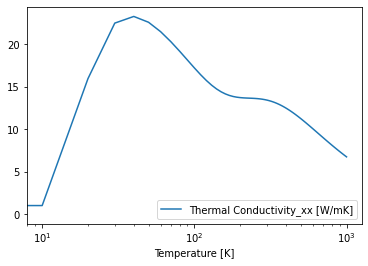

In [22]:
g_df = load_anphon_kl(g_RTAfuture.outputs.kl_file)
g_df.plot(x="Temperature [K]", y="Thermal Conductivity_xx [W/mK]")
import matplotlib.pyplot as plt
plt.xscale("log")

In [23]:
g_RTAfuture.outputs.result_file

<SinglefileData: uuid: fd9d58da-b9ed-4a09-81be-bd8c17227931 (pk: 59626)>

In [24]:
class analzePhononOptions:
    def __init__(self, **kwargs):
        self.options= {'temp': None, 'mode': None, 'kpoint': None, 
'calc': 'kappa_boundary', 'isotope': None, 'average_gamma': True, 
'size': '1e+6', 'length': None, 'direction': None}

a = analzePhononOptions()
print(a.options)

{'temp': None, 'mode': None, 'kpoint': None, 'calc': 'kappa_boundary', 'isotope': None, 'average_gamma': True, 'size': '1e+6', 'length': None, 'direction': None}


In [25]:
#codename = "analyze_phonon@tutor"
#code = Code.get_from_string(codename)
code = code_analyze_phonons

builder = code.get_builder()
builder.cwd = g_cwd
#builder.norder = g_norder
builder.prefix = g_wd
builder.calc = Str("kappa_boundary")
# builder.size = Float(1.0e+6)
builder.file_result = g_RTAfuture.outputs.result_file
builder.param = Dict(dict={"size": 1e+6})

key = "ap_kappa"
g_ap_kappa_future = nodebank.load(key)
if g_ap_kappa_future is None:   
    g_ap_kappa_future = submit(builder)
    print(g_ap_kappa_future)
    wait_for_node_finished(g_ap_kappa_future, 5)
    if g_ap_kappa_future.is_finished_ok:
         nodebank.dump(key,g_ap_kappa_future)

uuid: 22564c4e-e4e1-49c6-8054-92a7b8136ae0 (pk: 59632) (aiida.calculations:alamode.analyze_phonons)
wait another 5 sec.
wait another 5 sec.
True True


In [26]:
code = code_analyze_phonons

builder = code.get_builder()
builder.cwd = g_cwd
builder.prefix = g_wd
builder.calc = Str("tau")
# builder.size = Float(1.0e+6)
builder.file_result = g_RTAfuture.outputs.result_file
builder.param = Dict(dict={"temp": 300.0})

key = "ap_tau"
g_ap_tau_future = nodebank.load(key)
if g_ap_tau_future is None:   
    g_ap_tau_future = submit(builder)
    print(g_ap_tau_future)
    wait_for_node_finished(g_ap_tau_future, 5)
    if g_ap_tau_future.is_finished_ok:
         nodebank.dump(key,g_ap_tau_future)

uuid: 144fb9a4-7571-4da0-a913-e1d25048bde6 (pk: 59641) (aiida.calculations:alamode.analyze_phonons)
wait another 5 sec.
wait another 5 sec.
True True


In [27]:
code = code_analyze_phonons

builder = code.get_builder()
builder.cwd = g_cwd
builder.prefix = g_wd
builder.calc = Str("cumulative")
# builder.size = Float(1.0e+6)
builder.file_result = g_RTAfuture.outputs.result_file
builder.param = Dict(dict={"temp": 300.0, "length": "10000:5"})


key = "ap_cum"
g_ap_cum_future = nodebank.load(key)
if g_ap_cum_future is None:   
#if True:
    g_ap_cum_future = submit(builder)
    print(g_ap_cum_future)
    wait_for_node_finished(g_ap_cum_future, 5)
    if g_ap_cum_future.is_finished_ok:
         nodebank.dump(key,g_ap_cum_future)

uuid: 8e56e2cc-f7c5-415a-982f-ee690b65ac7f (pk: 59650) (aiida.calculations:alamode.analyze_phonons)
wait another 5 sec.
wait another 5 sec.
True True


In [28]:
values = g_ap_cum_future.outputs.cumulative.get_array("values")
values

array([[ 0.00000e+00,  0.00000e+00,  0.00000e+00, ...,  0.00000e+00,
         0.00000e+00,  0.00000e+00],
       [ 5.00000e+00,  8.21880e-01, -1.86702e-07, ...,  1.03017e-12,
        -8.18200e-13,  9.55541e-01],
       [ 1.00000e+01,  5.85602e+00, -2.40329e-07, ...,  1.31585e-12,
         3.69325e-12,  8.16313e+00],
       ...,
       [ 9.98500e+03,  1.34167e+01,  2.30570e-07, ..., -2.67695e-10,
         6.97496e-11,  5.15685e+01],
       [ 9.99000e+03,  1.34167e+01,  2.30570e-07, ..., -2.67695e-10,
         6.97496e-11,  5.15685e+01],
       [ 9.99500e+03,  1.34167e+01,  2.30570e-07, ..., -2.67695e-10,
         6.97496e-11,  5.15685e+01]])

In [29]:
values = g_ap_cum_future.outputs.cumulative.get_array("values").astype(float)
splitted_header = g_ap_cum_future.outputs.cumulative.get_array("columns")
df = pd.DataFrame(values, columns=splitted_header)
df

,L [nm],kappa xx [W/mK],kappa xy [W/mK],kappa xz [W/mK],kappa yx [W/mK],kappa yy [W/mK],kappa yz [W/mK],kappa zx [W/mK],kappa zy [W/mK],kappa zz [W/mK]
0,0.0,0.00000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
1,5.0,0.82188,-1.867020e-07,1.030170e-12,-1.867020e-07,0.821879,-8.181970e-13,1.030170e-12,-8.182000e-13,0.955541
2,10.0,5.85602,-2.403290e-07,1.315870e-12,-2.403290e-07,5.856020,3.693250e-12,1.315850e-12,3.693250e-12,8.163130
3,15.0,7.50387,-2.780080e-07,2.030240e-12,-2.780080e-07,7.503870,2.639950e-12,2.030240e-12,2.639940e-12,10.760200
4,20.0,7.61119,-2.820800e-07,1.581060e-12,-2.820800e-07,7.611190,2.639950e-12,1.581040e-12,2.639940e-12,12.237600
...,...,...,...,...,...,...,...,...,...,...
1995,9975.0,13.41670,2.305700e-07,-2.676950e-10,2.305700e-07,13.416700,6.974950e-11,-2.676950e-10,6.974960e-11,51.568500
1996,9980.0,13.41670,2.305700e-07,-2.676950e-10,2.305700e-07,13.416700,6.974950e-11,-2.676950e-10,6.974960e-11,51.568500
1997,9985.0,13.41670,2.305700e-07,-2.676950e-10,2.305700e-07,13.416700,6.974950e-11,-2.676950e-10,6.974960e-11,51.568500
1998,9990.0,13.41670,2.305700e-07,-2.676950e-10,2.305700e-07,13.416700,6.974950e-11,-2.676950e-10,6.974960e-11,51.568500


<AxesSubplot:xlabel='L [nm]'>

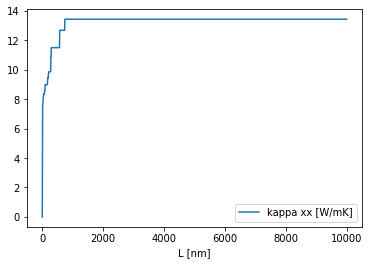

In [30]:
df.plot(x= "L [nm]", y='kappa xx [W/mK]')

## anphon spectra

In [31]:
#codename = "anphon@tutor"
#code = Code.get_from_string(codename)
code = code_anphon

builder = code.get_builder()
builder.structure = g_primstructure
builder.prefix = g_wd
builder.cwd = g_cwd
builder.norder = g_norder
builder.fcsxml = g_alm_opt.outputs.input_ANPHON_file
builder.mode = Str("RTA")
builder.kappa_spec = Int(1) # spectra
builder.qmesh = g_qmesh
eparam = {"EMIN":0, "EMAX":550, "DELTA_E": 10.0}
builder.param= Dict(dict={"general": eparam})

key = "RTAspec"
g_RTAspecfuture = nodebank.load(key,g_force)
#if g_RTAspecfuture is None:  
if True:   
    g_RTAspecfuture = submit(builder)
    print(g_RTAspecfuture)
    wait_for_node_finished(g_RTAspecfuture, 5)
    if g_RTAspecfuture.is_finished_ok:
         nodebank.dump(key,g_RTAspecfuture)


uuid: 4c200cf1-0a07-4170-87cb-865217ed9102 (pk: 59660) (aiida.calculations:alamode.anphon)
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
True True


In [32]:
g_df = load_anphon_kl_spec(g_RTAspecfuture.outputs.kl_spec_file)

In [33]:
print(np.unique(g_df["Temperature [K]"].values))
g_df_select = g_df[g_df["Temperature [K]"]==300]

[   0.   10.   20.   30.   40.   50.   60.   70.   80.   90.  100.  110.
  120.  130.  140.  150.  160.  170.  180.  190.  200.  210.  220.  230.
  240.  250.  260.  270.  280.  290.  300.  310.  320.  330.  340.  350.
  360.  370.  380.  390.  400.  410.  420.  430.  440.  450.  460.  470.
  480.  490.  500.  510.  520.  530.  540.  550.  560.  570.  580.  590.
  600.  610.  620.  630.  640.  650.  660.  670.  680.  690.  700.  710.
  720.  730.  740.  750.  760.  770.  780.  790.  800.  810.  820.  830.
  840.  850.  860.  870.  880.  890.  900.  910.  920.  930.  940.  950.
  960.  970.  980.  990. 1000.]


<AxesSubplot:xlabel='Frequency [cm^-1]'>

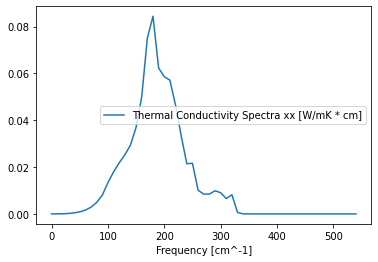

In [34]:
g_df_select.plot(x=g_df.columns[1], y=g_df.columns[2])